In [235]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split

In [236]:
data = pd.read_csv("./urbanGB.all/urbanGB.txt", header = None, names = ['x', 'y'])

In [238]:
X, X_test = train_test_split(data, test_size=0.2, random_state=420)

### k-średnich

należy ustalić ile wynosi optymalne k przy pomocy wykresu  
parametr score określa (ze znakiem -) jak dużą sumę kwadratów odległości od centrów mamy. minimalizacja tej wartości powinna sprowadzić nas do dobrych rozwiązań

#### n_clusters = ?

In [245]:
scores = []
for n in range(1,10):
    kmeans = KMeans(n_clusters=n, random_state = 420).fit(X)
    scores.append(-kmeans.score(X))

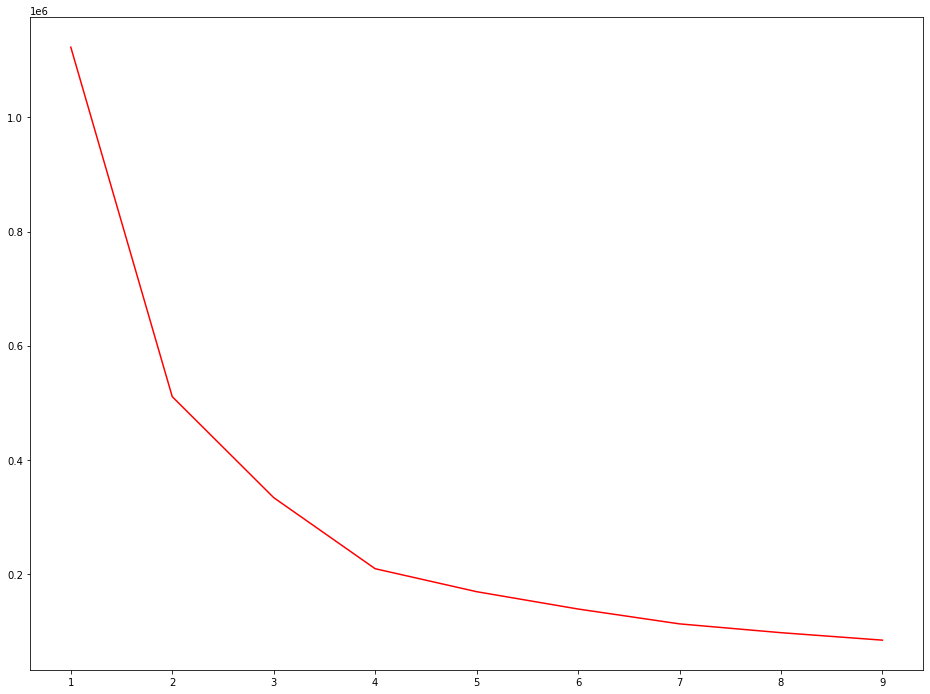

In [246]:
plt.figure(figsize = (16,12))
plt.plot([i for i in range(1, 10)], scores[0:9] )

#### tzw. "łokieć" wykresu wskazuje, że optymalna liczba klastrów to 4

In [247]:
kmeans = KMeans(n_clusters=4, random_state = 420).fit(X)
labels = kmeans.labels_
X['labels'] = labels

C:\Users\mipec\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


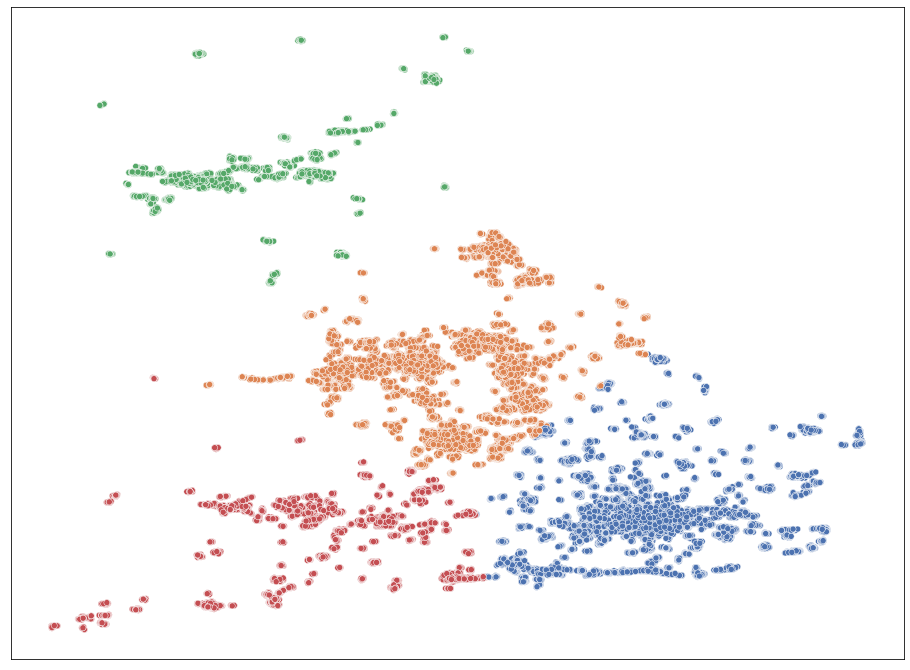

In [255]:
fig, ax = plt.subplots(1,1, figsize = (16,12))
sns.scatterplot('x', 'y', data=X, hue='labels', palette = 'deep')
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
ax.get_legend().remove()
plt.show()

### Gaussian Mixture

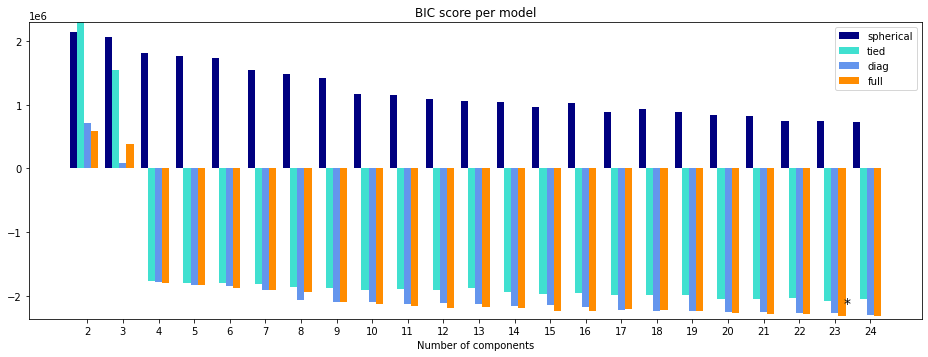

In [262]:
lowest_bic = np.infty
bic = []
n_components_range = range(2, 25)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
    
# oznaczenie najlepszego w
    
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

najlepszy `covariance type` dla tego zadania wydaje się być 'full', sprawdzmy optymalną liczbę komponentów - metoda łokcia na krzywej BIC

<BarContainer object of 23 artists>

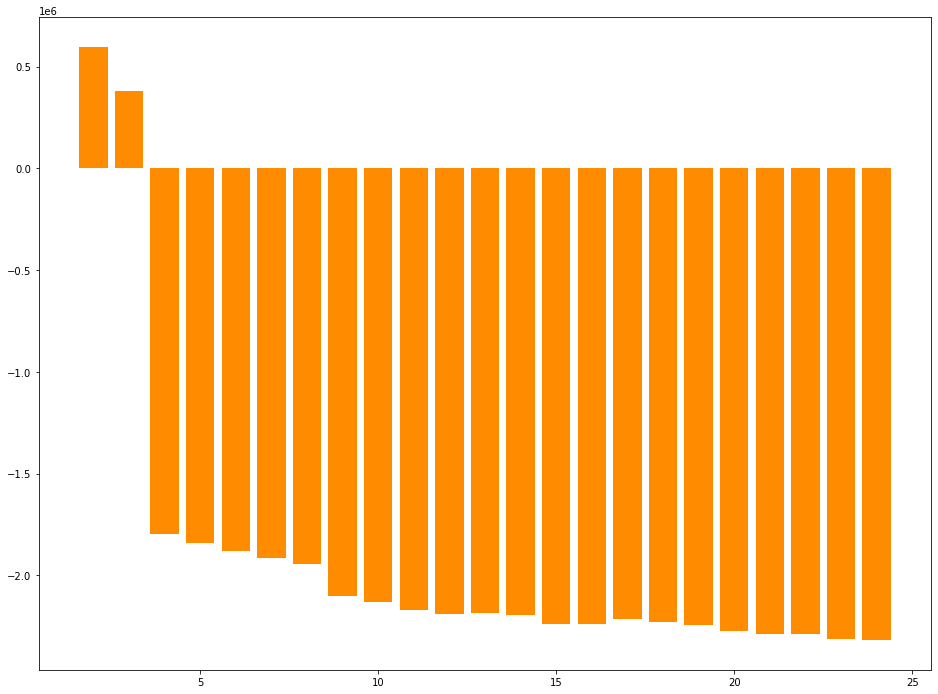

In [292]:
plt.figure(figsize=(16, 12))
plt.bar(np.array(n_components_range), bic[69:], color = 'darkorange')

In [313]:
bicgrad = [0]
bicgrad += [bic[i+1]-bic[i] for i in range(69, 91)]

<BarContainer object of 23 artists>

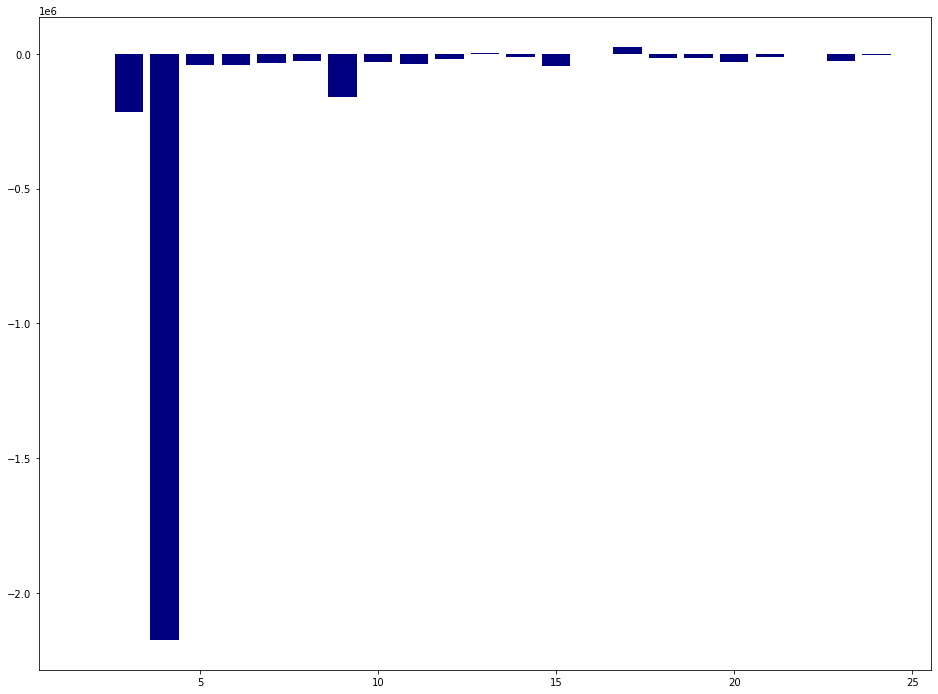

In [314]:
plt.figure(figsize=(16, 12))
plt.bar(np.array(n_components_range), np.array(bicgrad), color = 'navy')

wykres gradientu wyników bic przy `covariance type` = 'full'

<BarContainer object of 20 artists>

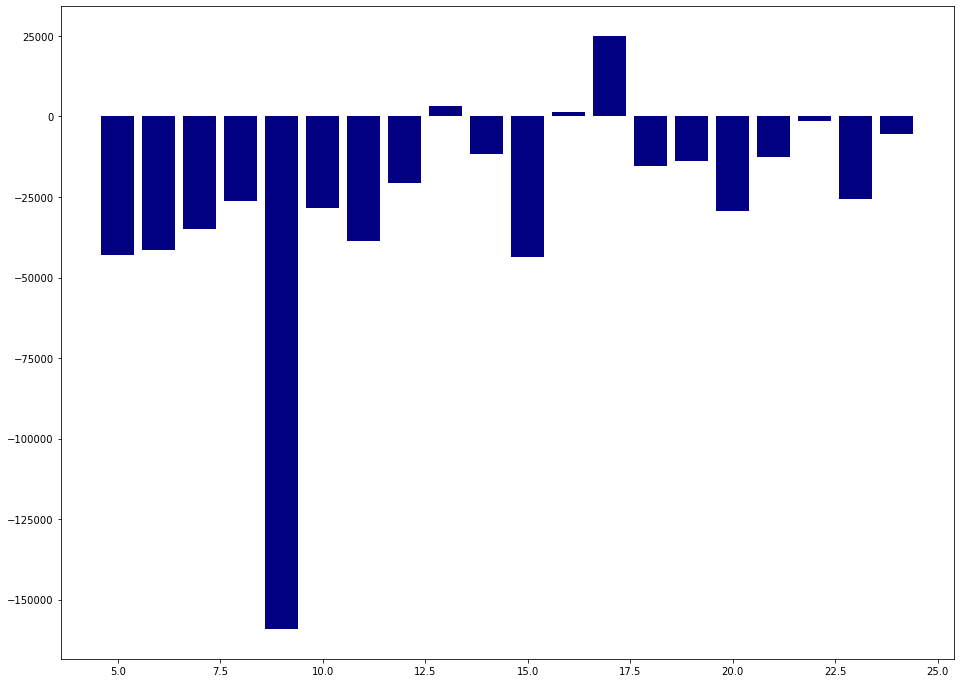

In [315]:
plt.figure(figsize=(16, 12))
plt.bar(np.array(n_components_range)[3:], np.array(bicgrad)[3:], color = 'navy')

jeden ze słupków bardzo zaburzał percepcję, na poprawionym wykresie można zobaczyć, że nasz zysk maleje ze wzrostem liczby komponentów, nie ma klarownego zwycięzcy, zdecydujmy się na 19 komponentów

C:\Users\mipec\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'remove'

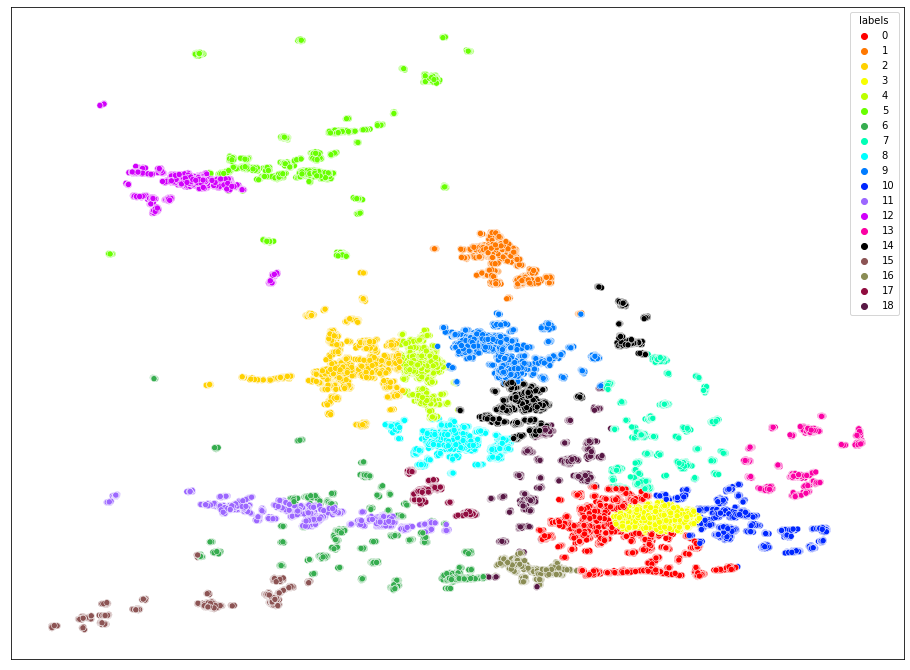

In [336]:
gm = GaussianMixture(n_components=19, covariance_type='full', random_state=420).fit(X)
X['labels'] = gm.predict(X)
colors = ['#FF0000', '#FF7800', '#FFD100', '#F7FF00', '#BDFF00', '#68FF00', '#36AD4F', '#00FFB6', '#00FFFF', '#007CFF',
          '#0027FF','#9C67FF', '#D100FB', '#FB00A4', '#000000', '#8C5454', '#8A8C54', '#900C3F', '#581845']
custompalette = sns.set_palette(sns.color_palette(colors))
plt.figure(figsize = (16,12))
sns.scatterplot('x', 'y', data=X, hue='labels', palette = colors)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
ax.get_legend().remove()
plt.show()

wygląda w miarę sensownie, dziwne zachowanie czarnego klastra

In [388]:
X = data.sample(10000)
normalized_X=(X-X.mean())/X.std()
X['x'] = X['x'].apply(lambda x: x*250)
X['y'] = X['y'].apply(lambda x: x*400)

In [389]:
scores = []
for n in range(1,10):
    kmeans = KMeans(n_clusters=n, random_state = 420).fit(X)
    scores.append(-kmeans.score(X))

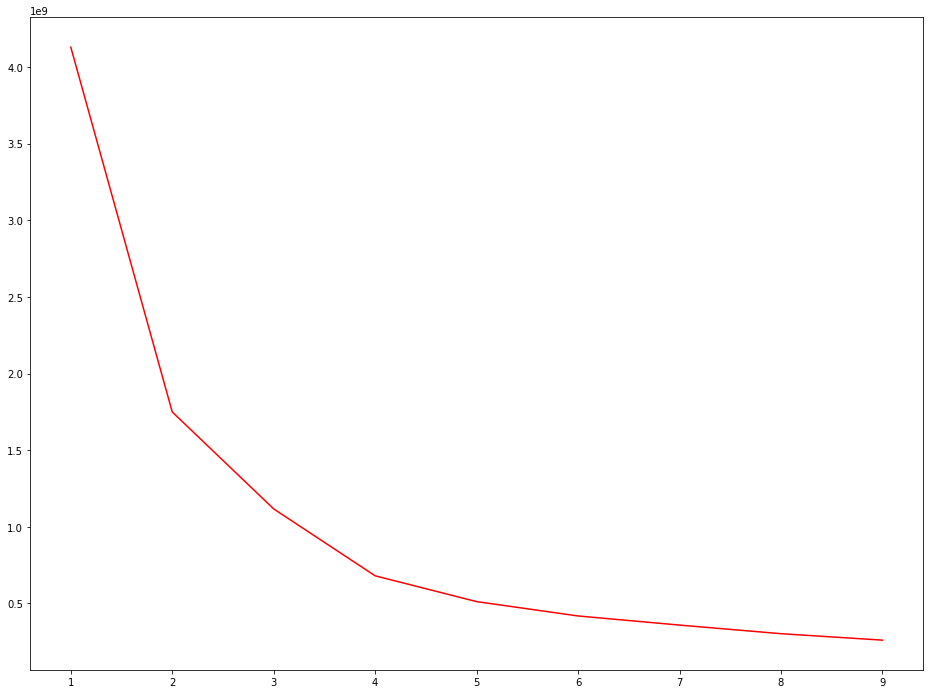

In [390]:
plt.figure(figsize = (16,12))
plt.plot([i for i in range(1, 10)], scores[0:9] )

C:\Users\mipec\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


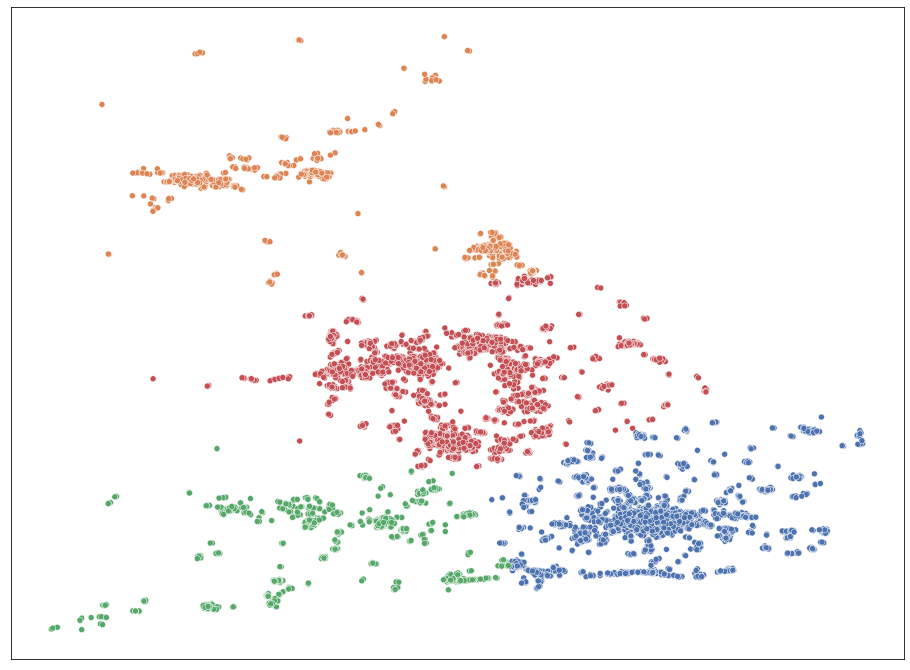

In [391]:
kmeans = KMeans(n_clusters=4, random_state = 420).fit(X)
labels = kmeans.labels_
X['labels'] = labels
fig, ax = plt.subplots(1,1, figsize = (16,12))
sns.scatterplot('x', 'y', data=X, hue='labels', palette = 'deep')
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
ax.get_legend().remove()
plt.show()